# Neural Object Detection: Practice
## Part 2: SSD training

*Ilya Zakharkin, November 2020*

---
### This notebook requires a GPU runtime to run.
### Please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"
---

Previous year there was a [good Computer Vision practice lesson](https://www.youtube.com/watch?v=XSPYe4-y4HE) (RUS), its [notebooks](https://drive.google.com/drive/folders/1ZpS8oyI__3QvjoIwVZwur4I5e4qIExPS?usp=sharing).

This year we will master inference and training of the SSD neural network discussed on the lecture.

This notebook is based on [mmdetection colab tutorial](https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb).

# MMDetection Tutorial

Welcome to MMDetection! This is the official colab tutorial for using MMDetection. In this tutorial, you will learn
- Perform inference with a MMDet detector.
- Train a new detector with a new dataset.

Let's start!


## Install MMDetection

In [2]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [4]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array-record                  0.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         23.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
build                         0.10.0
CacheControl                  0.12.11
cac

In [35]:
!pwd
%cd /content
!rm -rf mmdetection/

/content/mmdetection
/content


In [36]:
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!git checkout d5dbc0e2ef9bf89e6fc99e163b4c0c9b511846d3


Cloning into 'mmdetection'...
remote: Enumerating objects: 36063, done.
remote: Counting objects: 100% (717/717), done.
remote: Compressing objects: 100% (450/450), done.
remote: Total 36063 (delta 353), reused 537 (delta 258), pack-reused 35346
Receiving objects: 100% (36063/36063), 52.10 MiB | 26.58 MiB/s, done.
Resolving deltas: 100% (25291/25291), done.
/content/mmdetection
Note: switching to 'd5dbc0e2ef9bf89e6fc99e163b4c0c9b511846d3'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at d5dbc0e2 [Feature] Add F

In [25]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html

# # Install mmdetection
# !rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

# !pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html
Cloning into 'd5dbc0e'...
fatal: repository 'https://github.com/open-mmlab/mmdetection.git/tree/d5dbc0e/' not found
[Errno 2] No such file or directory: 'mmdetection'
/content/mmdetection


In [6]:
!pip install mmengine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.1/372.1 kB 11.3 MB/s eta 0:00:00


In [5]:
# # !pip install mmcv==2
# # !pip install "mmcv>=2.0.0" -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html
# !pip install "mmcv>=1.3.17, <=1.8.0" -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.4/605.4 kB 39.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mmcv: filename=mmcv-1.7.1-py2.py3-none-any.whl size=930716 sha256=45f541d26d2b240e7c740be0768dffe871e2e3c0ef6a334274d04b34594d9414
  Stored in directory: /root/.cache/pip/wheels/f8/f9/e3/7e8ab9b98ee9e91fcb677bea6a1ca23b755ddf87a982216acf
Successfully built mmcv
  Attempting uninstall: mmcv
    Found existing installation: mmcv 2.0.0
    Uninstalling mmcv-2.0.0:
      Successfully uninstalled mmcv-2.0.0


In [8]:
%%bash
pip install -U openmim
mim install "mmdet<3"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 3.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.5 MB/s eta 0:00:00


In [7]:
# !mim install mmcv-full
# import mmcv
# print(mmcv.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html
1.7.1


In [1]:
# !pip install mmcv-full==1.0.5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 92, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    st

In [9]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.11.0+cu113 False
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
2.28.2
11.3
GCC 9.3


/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Perform inference with a MMDet detector
MMDetection already provides high level APIs to do inference and training.

Let's compare two models: Mask-RCNN (more heavy model) and SSD300 (more lightweight model).

Download the Mask-RCNN weights:

In [37]:
!mkdir checkpoints
# !wget -c https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
!wget -c https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2023-05-13 22:20:15--  https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 8.25.82.214, 8.25.82.210, 8.25.82.207, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.25.82.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/octet-stream]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M  9.19MB/s    in 18s     

2023-05-13 22:20:34 (9.18 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



Download the SSD300 weights:

In [38]:
# !wget -c http://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20200307-a92d2092.pth \
!wget -c https://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20210803_015428-d231a06e.pth \
      -O checkpoints/ssd300_coco_20210803_015428-d231a06e.pth

--2023-05-13 22:20:34--  https://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20210803_015428-d231a06e.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 8.25.82.214, 8.25.82.210, 8.25.82.207, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.25.82.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137242646 (131M) [application/octet-stream]
Saving to: ‘checkpoints/ssd300_coco_20210803_015428-d231a06e.pth’

checkpoints/ssd300_ 100%[===================>] 130.88M  9.51MB/s    in 14s     

2023-05-13 22:20:48 (9.23 MB/s) - ‘checkpoints/ssd300_coco_20210803_015428-d231a06e.pth’ saved [137242646/137242646]



In [39]:
!ls checkpoints

mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
ssd300_coco_20210803_015428-d231a06e.pth


We will use internal API methods for initialization, inference and visualization ofr model predictions:

In [41]:
!ls configs/faster_rcnn/

faster_rcnn_r101_caffe_fpn_1x_coco.py
faster_rcnn_r101_caffe_fpn_mstrain_3x_coco.py
faster_rcnn_r101_fpn_1x_coco.py
faster_rcnn_r101_fpn_2x_coco.py
faster_rcnn_r101_fpn_mstrain_3x_coco.py
faster_rcnn_r50_caffe_c4_1x_coco.py
faster_rcnn_r50_caffe_dc5_1x_coco.py
faster_rcnn_r50_caffe_dc5_mstrain_1x_coco.py
faster_rcnn_r50_caffe_dc5_mstrain_3x_coco.py
faster_rcnn_r50_caffe_fpn_1x_coco.py
faster_rcnn_r50_caffe_fpn_mstrain_1x_coco-person-bicycle-car.py
faster_rcnn_r50_caffe_fpn_mstrain_1x_coco-person.py
faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py
faster_rcnn_r50_caffe_fpn_mstrain_2x_coco.py
faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py
faster_rcnn_r50_caffe_fpn_mstrain_90k_coco.py
faster_rcnn_r50_fpn_1x_coco.py
faster_rcnn_r50_fpn_2x_coco.py
faster_rcnn_r50_fpn_bounded_iou_1x_coco.py
faster_rcnn_r50_fpn_giou_1x_coco.py
faster_rcnn_r50_fpn_iou_1x_coco.py
faster_rcnn_r50_fpn_mstrain_3x_coco.py
faster_rcnn_r50_fpn_ohem_1x_coco.py
faster_rcnn_r50_fpn_soft_nms_1x_coco.py
faster_rcnn_x101_32x4d_f

Mask-RCNN:

In [44]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = 'configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py'
# config = 'configs/faster_rcnn/faster-rcnn_r50-caffe_fpn_ms-3x_coco.py'

# Setup a checkpoint file to load
# checkpoint = 'checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'
checkpoint = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set the device to be used for evaluation
device='cuda:0' if torch.cuda.is_available() else "cpu"

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()


load checkpoint from local path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: roi_head.mask_head.convs.0.conv.weight, roi_head.mask_head.convs.0.conv.bias, roi_head.mask_head.convs.1.conv.weight, roi_head.mask_head.convs.1.conv.bias, roi_head.mask_head.convs.2.conv.weight, roi_head.mask_head.convs.2.conv.bias, roi_head.mask_head.convs.3.conv.weight, roi_head.mask_head.convs.3.conv.bias, roi_head.mask_head.upsample.weight, roi_head.mask_head.upsample.bias, roi_head.mask_head.conv_logits.weight, roi_head.mask_head.conv_logits.bias



FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [46]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config = 'configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
# initialize the detector
model = init_detector(config, checkpoint, device=device)

load checkpoint from local path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


In [47]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

/usr/local/lib/python3.10/dist-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


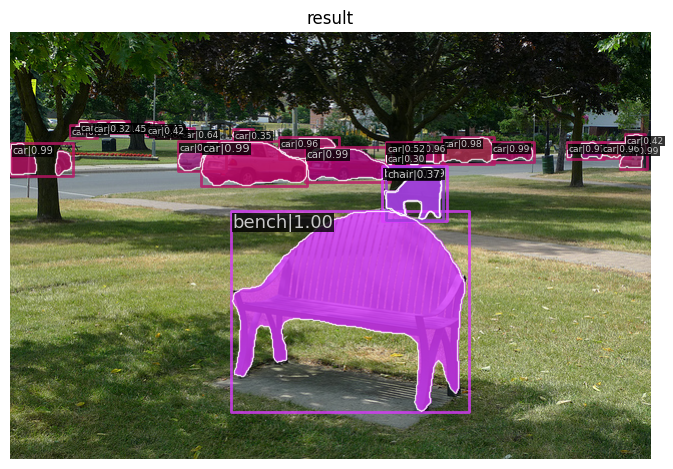

In [48]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

SSD300:

In [50]:
config = 'configs/ssd/ssd300_coco.py'
checkpoint = 'checkpoints/ssd300_coco_20210803_015428-d231a06e.pth'
model = init_detector(config, checkpoint, device=device)
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

load checkpoint from local path: checkpoints/ssd300_coco_20210803_015428-d231a06e.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: neck.l2_norm.weight, neck.extra_layers.0.0.conv.weight, neck.extra_layers.0.0.conv.bias, neck.extra_layers.0.1.conv.weight, neck.extra_layers.0.1.conv.bias, neck.extra_layers.1.0.conv.weight, neck.extra_layers.1.0.conv.bias, neck.extra_layers.1.1.conv.weight, neck.extra_layers.1.1.conv.bias, neck.extra_layers.2.0.conv.weight, neck.extra_layers.2.0.conv.bias, neck.extra_layers.2.1.conv.weight, neck.extra_layers.2.1.conv.bias, neck.extra_layers.3.0.conv.weight, neck.extra_layers.3.0.conv.bias, neck.extra_layers.3.1.conv.weight, neck.extra_layers.3.1.conv.bias



AssertionError: ignored

In [51]:
!ls -la checkpoints

total 307740
drwxr-xr-x  2 root root      4096 May 13 22:20 .
drwxr-xr-x 15 root root      4096 May 13 22:20 ..
-rw-r--r--  1 root root 177867103 Nov  2  2021 mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
-rw-r--r--  1 root root 137242646 Nov  2  2021 ssd300_coco_20210803_015428-d231a06e.pth


**Insight**: Mask-RCNN weights 178Mb, and SSD weights 137Mb, and it logically corresponds to their quality: SSD sees less objects on the scenes, therefore it has more False Negatives.

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. reorganize the dataset into COCO format.
  2. reorganize the dataset into a middle format.
  3. implement a new dataset.

Usually we recommend to use the first two methods which are usually easier than the third.

In this tutorial, we gives an example that converting the data into the format of existing datasets like COCO, VOC, etc. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/tutorials/new_dataset.html#).

Firstly, let's download a tiny dataset obtained from [KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d). We select the first 75 images and their annotations from the 3D object detection dataset (it is the same dataset as the 2D object detection dataset but has 3D annotations). We convert the original images from PNG to JPEG format with 80% quality to reduce the size of dataset.

In [52]:
# download, decompress the data
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2023-05-13 22:27:02--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 8.25.82.214, 8.25.82.212, 8.25.82.209, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.25.82.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  7.58MB/s    in 0.9s    

2023-05-13 22:27:04 (7.58 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



In [53]:
# Check the directory structure of the tiny data

# Install tree first
!apt-get -q install tree
!tree kitti_tiny

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 1s (66.3 kB/s)
Selecting previously unselected package tree.
(Reading database ... 122519 files and directories currently installed.)
Preparing to unpack .../tree_1.8.0-1_amd64.deb ...
Unpacking tree (1.8.0-1) ...
Setting up tree (1.8.0-1) ...
Processing triggers for man-db (2.9.1-1) ...
kitti_tiny
├── training
│   ├── image_2
│   │   ├── 000000.jpeg
│   │   ├── 000001.jpeg
│   │   ├── 000002.jpeg
│   │   ├── 000003.jpeg
│   │   ├── 000004.jpeg
│   │   ├── 000005.jpeg
│   │   ├── 000006.jpeg
│   │   ├── 000007.jpeg
│   │   ├── 000008.jpeg
│   │   ├── 000009.jpeg
│   │   ├── 000010.jpeg

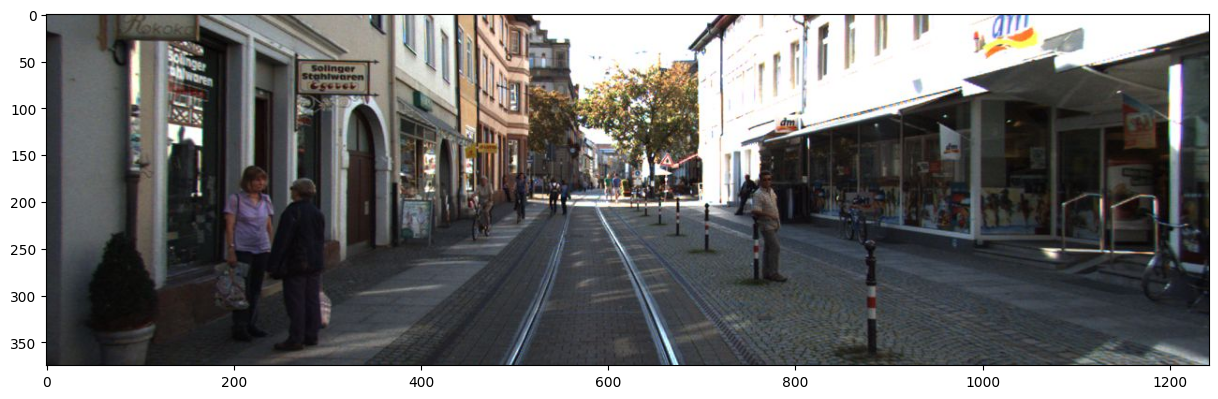

In [54]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('kitti_tiny/training/image_2/000073.jpeg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

After downloading the data, we need to implement a function to convert the kitti annotation format into the middle format. In this tutorial we choose to convert them in **`load_annotations`** function in a newly implemented **`KittiTinyDataset`**.

Let's take a look at the annotation txt file.



In [55]:
# Check the label of a single image
!cat kitti_tiny/training/label_2/000000.txt

Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01


According to the KITTI's documentation, the first column indicates the class of the object, and the 5th to 8th columns indicates the bboxes. We need to read annotations of each image and convert them into middle format MMDetection accept is as below:

```python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray> (n, 4),
            'labels': <np.ndarray> (n, ),
            'bboxes_ignore': <np.ndarray> (k, 4), (optional field)
            'labels_ignore': <np.ndarray> (k, 4) (optional field)
        }
    },
    ...
]
```

In [ ]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpeg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [56]:
from mmcv import Config

model_type = "ssd"

if model_type == "ssd":
  cfg = Config.fromfile('./configs/ssd/ssd300_coco.py')
elif model_type == "mask_rcnn":
  cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

In [57]:
cfg["data"]

{'samples_per_gpu': 8,
 'workers_per_gpu': 3,
 'train': {'type': 'RepeatDataset',
  'times': 5,
  'dataset': {'type': 'CocoDataset',
   'ann_file': 'data/coco/annotations/instances_train2017.json',
   'img_prefix': 'data/coco/train2017/',
   'pipeline': [{'type': 'LoadImageFromFile', 'to_float32': True},
    {'type': 'LoadAnnotations', 'with_bbox': True},
    {'type': 'PhotoMetricDistortion',
     'brightness_delta': 32,
     'contrast_range': (0.5, 1.5),
     'saturation_range': (0.5, 1.5),
     'hue_delta': 18},
    {'type': 'Expand',
     'mean': [123.675, 116.28, 103.53],
     'to_rgb': True,
     'ratio_range': (1, 4)},
    {'type': 'MinIoURandomCrop',
     'min_ious': (0.1, 0.3, 0.5, 0.7, 0.9),
     'min_crop_size': 0.3},
    {'type': 'Resize', 'img_scale': (300, 300), 'keep_ratio': False},
    {'type': 'Normalize',
     'mean': [123.675, 116.28, 103.53],
     'std': [1, 1, 1],
     'to_rgb': True},
    {'type': 'RandomFlip', 'flip_ratio': 0.5},
    {'type': 'DefaultFormatBundle'

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.


> - [SSD training issue 1](https://github.com/open-mmlab/mmdetection/issues/1203)
- [SSD training issue 2](https://github.com/open-mmlab/mmdetection/issues/2448)

In [58]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = 'kitti_tiny/'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image_2'

if model_type == "ssd":
  cfg.data.train.dataset.type = 'KittiTinyDataset'
  cfg.data.train.dataset.data_root = 'kitti_tiny/'
  cfg.data.train.dataset.ann_file = 'train.txt'
  cfg.data.train.dataset.img_prefix = 'training/image_2'
elif model_type == "mask_rcnn":
  cfg.data.train.type = 'KittiTinyDataset'
  cfg.data.train.data_root = 'kitti_tiny/'
  cfg.data.train.ann_file = 'train.txt'
  cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

if model_type == "ssd":
  cfg.model.bbox_head.num_classes = 3
  cfg.load_from = 'checkpoints/ssd300_coco_20210803_015428-d231a06e.pth'
elif model_type == "mask_rcnn":
  cfg.model.roi_head.bbox_head.num_classes = 3
  cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# ssd300_coco and ssd300_voc with 4gpu, 24 imgs per gpu and lr of 3e-3
cfg.optimizer.lr = 0.02 / 8.  # 3e-3
# cfg.lr_config.warmup = None
cfg.lr_config.policy = 'step'
cfg.lr_config.warmup = 'linear'
cfg.lr_config.warmup_ratio = 1.0 / 1e10

cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
input_size = 300
model = dict(
    type='SingleStageDetector',
    pretrained='open-mmlab://vgg16_caffe',
    backbone=dict(
        type='SSDVGG',
        input_size=300,
        depth=16,
        with_last_pool=False,
        ceil_mode=True,
        out_indices=(3, 4),
        out_feature_indices=(22, 34),
        l2_norm_scale=20),
    neck=None,
    bbox_head=dict(
        type='SSDHead',
        in_channels=(512, 1024, 512, 256, 256, 256),
        num_classes=3,
        anchor_generator=dict(
            type='SSDAnchorGenerator',
            scale_major=False,
            input_size=300,
            basesize_ratio_range=(0.15, 0.9),
            strides=[8, 16, 32, 64, 100, 300],
            ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2]]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[0.1, 0.1, 0.2, 0.2])),
    train_cfg=dict(
        assigner=dict(
            type='MaxIoUAssigner',


### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [65]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build the detector
model = build_detector( cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience

# model.CLASSES = ["1", '2', '3', '4']
# model.CLASSES = datasets[0].CLASSES


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

KeyError: ignored

### Understand the log
From the log, we can have a basic understanding the training process and know how well the detector is trained.

Firstly, the ResNet-50 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more cost. The log shows that all the weights of the ResNet-50 backbone are loaded except the `conv1.bias`, which has been merged into `conv.weights`.

Second, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the detector we actually using is Faster R-CNN, the weights in mask branch, e.g. `roi_head.mask_head`, are `unexpected key in source state_dict` and not loaded.
The original Mask R-CNN is trained on COCO dataset which contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layer of the pre-trained Mask R-CNN for classification has different weight shape and is not used.

Third, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 54.1 mAP on the val dataset,
 not bad!

## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

In [63]:
img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


AssertionError: ignored

Feel free to test on your images:

In [ ]:
!wget <your image uri>

In [ ]:
!ls

In [64]:
img = mmcv.imread('kitti_tiny/training/image_2/000060.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

AssertionError: ignored

## Useful links

- Andrej Karpathy (Tesla AI director) [keynote on multi-task learning](https://slideslive.com/38917690/multitask-learning-in-the-wilderness) (ENG)
- [CV practice 2019](https://www.youtube.com/watch?v=XSPYe4-y4HE) (RUS)
- [Habrahabr post: Classification & Representation](https://habr.com/ru/company/mipt/blog/458190/) (RUS)
- [Habrahabr post: Detection & Tracking](https://habr.com/ru/company/mipt/blog/450732/) (RUS)
